# TP2: Interação e Concorrência

#### 

Fernando Augusto Marques Lobo, A87988

João Pedro Correia Oliveira, A87945

#### Problem:

Each group of students has a number assigned, N. Now, you have to use
a quantum algorithm to find s 
$$s = N mod 8$$
in an unsorted list.

Since our group number is 1, the binary number we intend to find is 001 and in order to find it we can use the Grover's algorithm.

#### Initialization:

In [1]:
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.tools.visualization import *
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
from qiskit.compiler import transpile
from qiskit.visualization import plot_circuit_layout
from qiskit.tools.monitor import backend_overview, backend_monitor

import qiskit.tools.jupyter

import matplotlib.pyplot as plt
%matplotlib inline

Atribuition of the Quantum and Classical registers with 3 qubits (since 8 is defined by 3 bits in binary) and set of the qasm and statevector simulators.

In [2]:
x = 3
qr_x = QuantumRegister(x, 'x')
cr = ClassicalRegister(x,'cr')
backend = Aer.get_backend("qasm_simulator")
backend_state = Aer.get_backend("statevector_simulator")

Now we add three Hadamard gates in each one of the qubits, in order to create superposition.

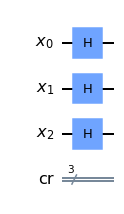

In [3]:
init = QuantumCircuit(qr_x, cr)
init.h(qr_x)
init.draw('mpl')

We can also see the three bits states this way.

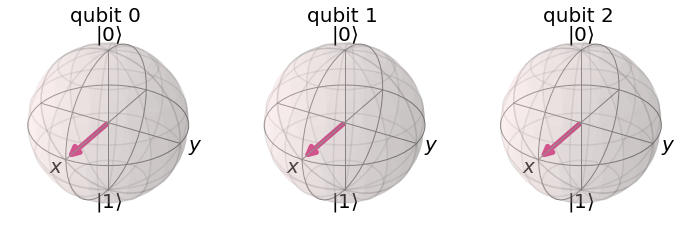

In [4]:
psi_vector = execute(init, backend_state).result().get_statevector()
plot_bloch_multivector(psi_vector)

#### Defining the phase oracle:

So in order to change the phase of the element we're searching we need to add an $X$ gate to the second and the last bits so that this way we set them to zero.
After that we need to implement a $CCZ$ gate. So, to do that, we aply an $H$ gate in the last bit, followed by a $CCX$ gate and lastely add another $H$ gate in the same bit as before.
Then once again we add the $X$ gates the same way as before.

In [5]:
def phase_oracle(circuit, qr):
    #X gates
    circuit.x(qr_x[1])
    circuit.x(qr_x[2])
    
    #CCZ gate
    circuit.h(qr_x[2])
    circuit.ccx(qr_x[0],qr_x[1],qr_x[2])
    circuit.h(qr_x[2])
    
    #X gates
    circuit.x(qr[2])
    circuit.x(qr[1])

And this is how it looks like.

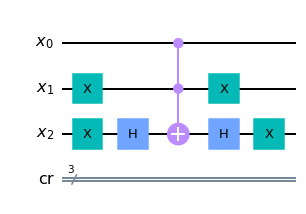

In [6]:
oracle = QuantumCircuit(qr_x, cr)
phase_oracle(oracle, qr_x)
oracle.draw('mpl')

#### Amplifying:

At this point we need to amplify the amplitude of our element. We can do it with the following function.

In [7]:
def diffuser(circuit, qr_x):
    
    #H + X gates
    circuit.h(qr_x)
    circuit.x(qr_x)
    
    #CCZ gate
    circuit.h(qr_x[2])
    circuit.ccx(qr_x[0],qr_x[1],qr_x[2])
    circuit.h(qr_x[2])
    
    #H + X gates
    circuit.x(qr_x)
    circuit.h(qr_x)

So the difuser would look like this.

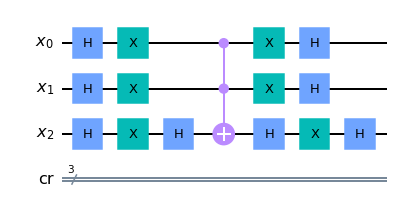

In [8]:
amp = QuantumCircuit(qr_x, cr)
diffuser(amp, qr_x)
amp.draw('mpl')

#### Measuring:

Finally we generate the full circuit and add the measurement gates, and since the number of attempts we need to get a better result is given through $\sqrt{N}$, where $N$ is the number of elements, we'll apply it twice, since the floor of $\sqrt{8}$ is 2.

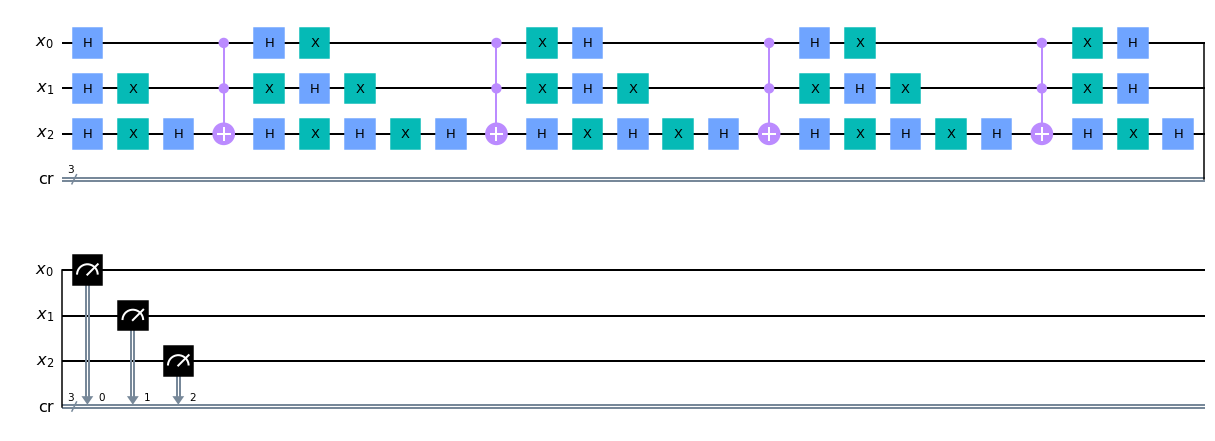

In [9]:
measure = QuantumCircuit(qr_x, cr)
measure.measure(qr_x, cr)

cr=ClassicalRegister(x,'cr')
qc_Grover= QuantumCircuit(qr_x, cr)

#Init
qc_Grover.h(qr_x)

#Oracle and diffuser 

for t in range(2):

    phase_oracle(qc_Grover, qr_x)

    diffuser(qc_Grover,qr_x)

#Measure
qc_Grover.measure(qr_x,cr)

qc_Grover.draw(output='mpl')

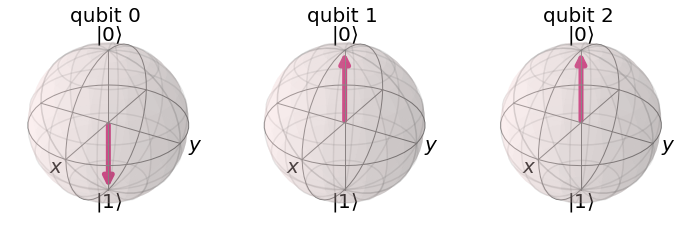

In [10]:
psi_vector = execute(qc_Grover, backend_state).result().get_statevector()
plot_bloch_multivector(psi_vector)

As we can see in the next histogram the values are really good, unlike the ones we would get if we had applyed it once.

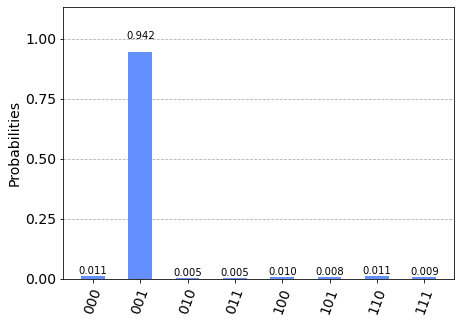

In [11]:
shots=1024
backend = Aer.get_backend("qasm_simulator")
result = execute(qc_Grover, backend, shots=shots).result()
counts = result.get_counts(qc_Grover)
plot_histogram(counts)

#### Noise simulation:

It's possible now to do an application of noise in the simulation and to do so we need to set the IBMQ account and get the machines available.

In [12]:
#IBMQ.save_account('eb5ade7dd87032a82421f0aac7473e17c587d231e6b045f70c838c1ea03625da9839e4bd573b3cb479aa620ae95ecd10af2c5b79a3340b98b45369b0f83809dc')

provider = IBMQ.load_account()
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

In [13]:
%qiskit_backend_overview

At this point we select one of the above, and we decided to opt for the "ibmqx2", since it has a higher average measurement error.

In [14]:
my_provider_ibmq = IBMQ.get_provider(hub='ibm-q', group='open', project='main') 

backend_device = my_provider_ibmq.get_backend('ibmqx2')

backend_device

<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>

In [15]:
coupling_map = backend_device.configuration().coupling_map

In [16]:
noise_model = NoiseModel.from_backend(backend_device)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'id', 'measure', 'sx', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('cx', [4, 2]), ('cx', [2, 4]), ('cx', [3, 4]), ('cx', [4, 3]), ('cx', [3, 2]), ('cx', [2, 3]), ('cx', [1, 2]), ('cx', [2, 1]), ('cx', [0, 2]), ('cx', [2, 0]), ('cx', [0, 1]), ('cx', [1, 0]), ('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('reset', [4]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]


In [17]:
basis_gates = noise_model.basis_gates
print(basis_gates)

['cx', 'id', 'reset', 'rz', 'sx', 'x']


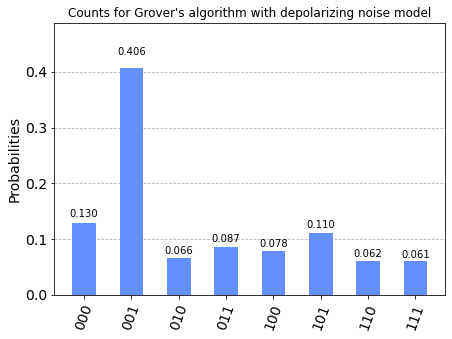

In [18]:
result_noise = execute(qc_Grover, backend, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()

counts_noise = result_noise.get_counts(qc_Grover)
plot_histogram(counts_noise, title="Counts for Grover's algorithm with depolarizing noise model")

In [19]:
print(counts)

{'001': 965, '000': 11, '100': 10, '110': 11, '010': 5, '101': 8, '111': 9, '011': 5}


In [20]:
print(counts_noise)

{'001': 416, '101': 113, '011': 89, '110': 63, '100': 80, '010': 68, '111': 62, '000': 133}


In [21]:
#Adaptation of the algorithm shown in classes

def resume(counts_raw):
    s000=s001=s010=s011=s100=s101=s110=s111=0
    k=counts_raw.keys()
    lk=list(k)
    for c in lk:
        if c == '000':
            s000 = s000 + counts_raw.get(c)
        elif c == '001':
            s001 = s001 + counts_raw.get(c)
        elif c == '010':
            s010 = s010 + counts_raw.get(c)
        elif c == '011':
            s011 = s011 + counts_raw.get(c)
        elif c == '100':
            s100 = s100 + counts_raw.get(c)
        elif c == '101':
            s101 = s101 + counts_raw.get(c)
        elif c == '110':
            s110 = s110 + counts_raw.get(c)
        else:
            s111 = s111 + counts_raw.get(c)
    return({'000': s000, '001': s001, '010': s010, '011': s011, '100': s100, '101': s101, '110': s110, '111': s111})

In [22]:
cn = resume(counts_noise)

In [23]:
c = resume(counts)

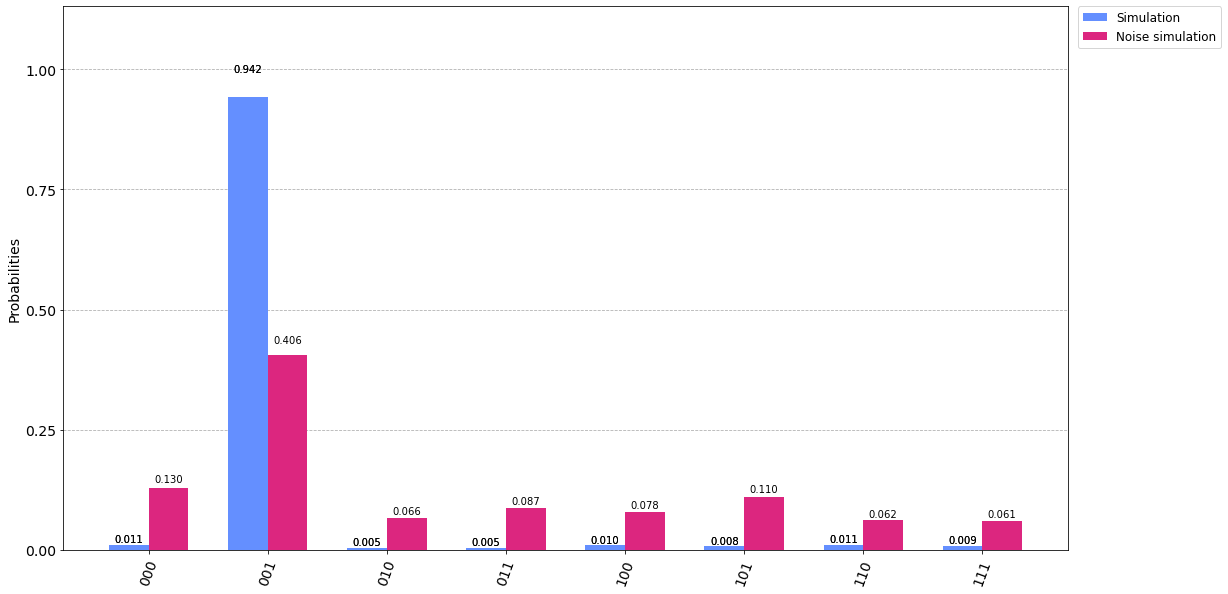

In [24]:
plot_histogram([c, cn], legend=[ "Simulation", "Noise simulation" ], figsize=(18, 10))

As we can see, noise adds significant errors, but as said before, we used the machine with the heighest errors so that we could obtain the worst results.

#### Running on a quantum computer:

In a first aproach we check for the available machines.

In [25]:
%qiskit_backend_overview
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [26]:
backend_overview()

ibmq_manila                  ibmq_quito                   ibmq_belem
-----------                  ----------                   ----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 24             Pending Jobs: 15             Pending Jobs: 0
Least busy:   False          Least busy:   False          Least busy:   True
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      148.5          Avg. T1:      80.3           Avg. T1:      75.9
Avg. T2:      68.2           Avg. T2:      71.2           Avg. T2:      75.6



ibmq_lima                    ibmq_santiago                ibmq_athens
---------                    -------------                -----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 7              Pending Jobs: 23             Pending Jobs: 2
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operatio

Since we only need 3 qubits and want less errors as possible we'll opt to use "ibmq_athens".

In [27]:
backend_device = provider.get_backend('ibmq_athens')
print("Running on: ", backend_device)

Running on:  ibmq_athens


In [28]:
backend_device

<IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>

In [29]:
backend_monitor(backend_device)

ibmq_athens
Configuration
-------------
    n_qubits: 5
    operational: True
    status_msg: active
    pending_jobs: 3
    backend_version: 1.3.19
    basis_gates: ['id', 'rz', 'sx', 'x', 'cx', 'reset']
    local: False
    simulator: False
    max_shots: 8192
    supported_instructions: ['acquire', 'sx', 'id', 'u3', 'rz', 'shiftf', 'play', 'x', 'reset', 'measure', 'setf', 'cx', 'delay', 'u1', 'u2']
    rep_delay_range: [0.0, 500.0]
    coupling_map: [[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3]]
    default_rep_delay: 250.0
    discriminators: ['quadratic_discriminator', 'linear_discriminator', 'hw_qmfk']
    pulse_num_channels: 9
    quantum_volume: 32
    sample_name: family: Falcon, revision: 4, segment: L
    u_channel_lo: [[{'q': 1, 'scale': (1+0j)}], [{'q': 0, 'scale': (1+0j)}], [{'q': 2, 'scale': (1+0j)}], [{'q': 1, 'scale': (1+0j)}], [{'q': 3, 'scale': (1+0j)}], [{'q': 2, 'scale': (1+0j)}], [{'q': 4, 'scale': (1+0j)}], [{'q': 3, 'scale': (1+0j)}]]
    backe

In [30]:
job_r = execute(qc_Grover, backend_device, shots=shots)

jobID_r = job_r.job_id()

print('JOB ID: {}'.format(jobID_r))

JOB ID: 60bd365f5f4eaa7379dafeeb


In [32]:
job_get=backend_device.retrieve_job("60bd365f5f4eaa7379dafeeb")

result_r = job_get.result()
counts_run = result_r.get_counts(qc_Grover)

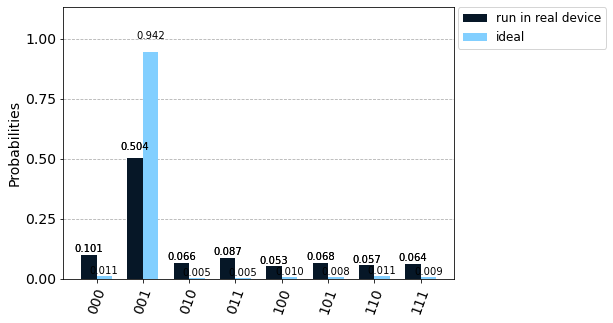

In [33]:
plot_histogram([counts_run, counts ], legend=[ 'run in real device', 'ideal'], color=['#061727','#82cfff'])

#### Optimization:

In this part we are going to use a level two of optimization and compare the results.

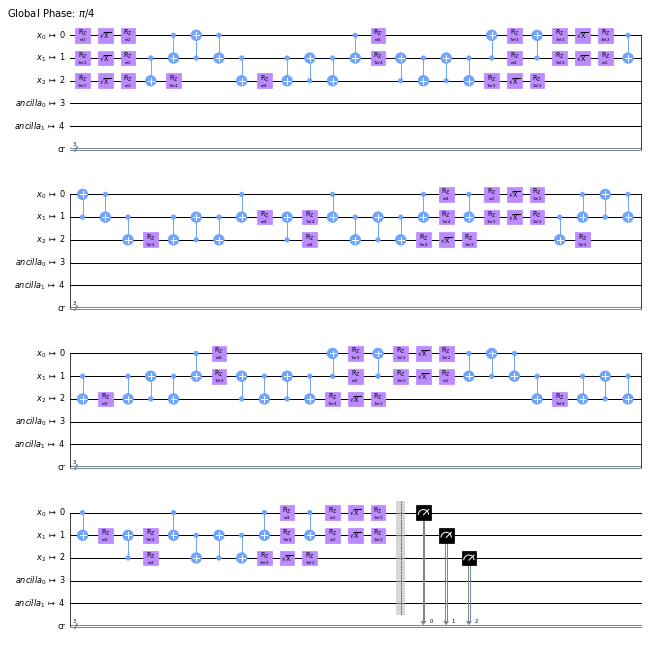

In [52]:
qc_t_real = transpile(qc_Grover, backend=backend_device)
qc_t_real.draw(output='mpl', scale=0.5)

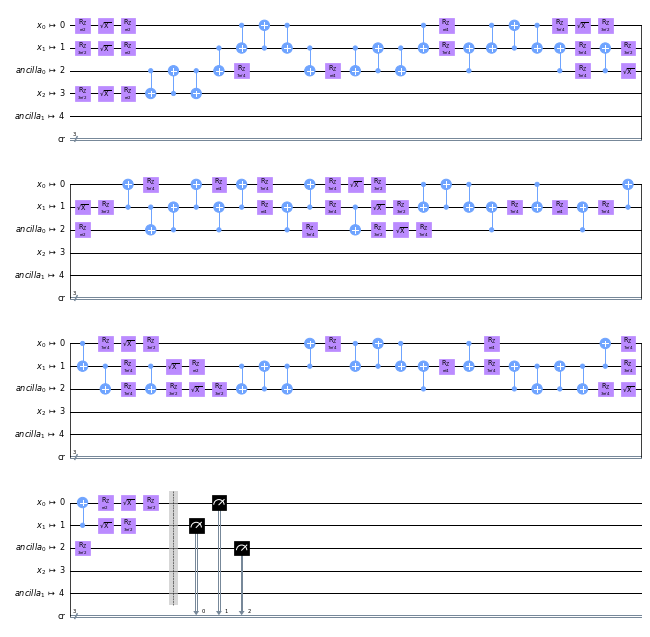

In [53]:
qc_optimized = transpile(qc_Grover, backend=backend_device, optimization_level=2)
qc_optimized.draw(output='mpl', scale=0.5)

In [54]:
qc_optimized.depth()

80

In [55]:
qc_t_real.depth()

90

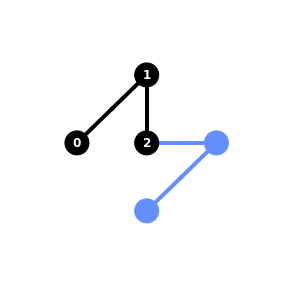

In [56]:
plot_circuit_layout(qc_t_real, backend_device)

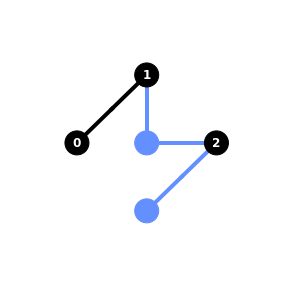

In [57]:
plot_circuit_layout(qc_optimized, backend_device)

In [58]:
job_exp = execute(qc_optimized, backend_device, shots = shots)

jobID = job_exp.job_id()

print('JOB ID: {}'.format(jobID))

job_exp.result().get_counts(qc_optimized)

JOB ID: 60bd398cbce7722f07ef9a9d


{'000': 80,
 '001': 416,
 '010': 91,
 '011': 121,
 '100': 66,
 '101': 73,
 '110': 91,
 '111': 86}

In [59]:
job_get_o=backend_device.retrieve_job("60bd398cbce7722f07ef9a9d")

result_real_o = job_get_o.result(timeout=3600, wait=5)

counts_opt = result_real_o.get_counts(qc_optimized)

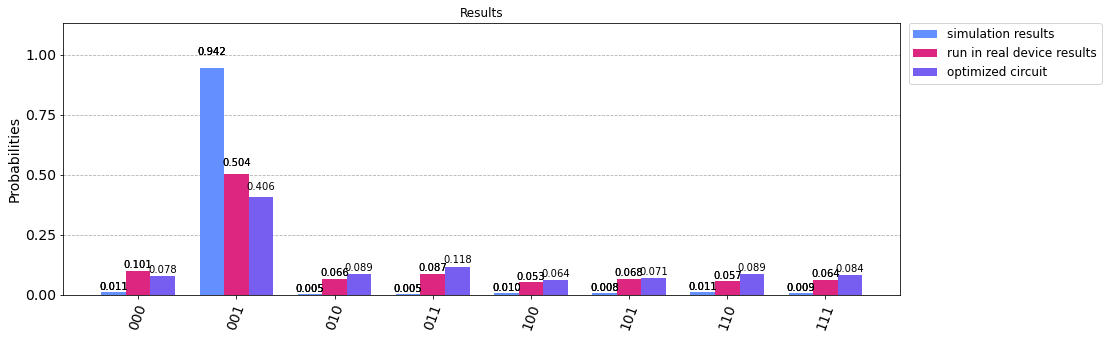

In [61]:
title = 'Results'
legend = [ 'simulation results','run in real device results', 'optimized circuit']

plot_histogram([counts, counts_run, counts_opt], legend = legend, title= title, figsize=(15, 5))

As we can see the results didn't improve much from the real and the optimized circuits. They actually were a little worse than the real device results.

#### Comparision between one and two, oracle and diffuser, repetitions:

Taking previous results into account, we can now verify if the circuit with just one repetition of the oracle and the diffuser generates better results.

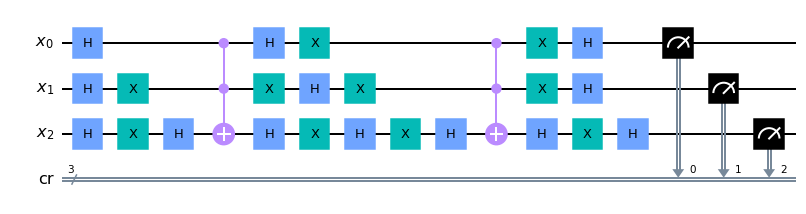

In [62]:
measure = QuantumCircuit(qr_x, cr)
measure.measure(qr_x, cr)

qc_G= QuantumCircuit(qr_x, cr)

#Init
qc_G.h(qr_x)

#Oracle and diffuser 

for t in range(1):

    phase_oracle(qc_G, qr_x)

    diffuser(qc_G,qr_x)

#Measure
qc_G.measure(qr_x,cr)

qc_G.draw(output='mpl')

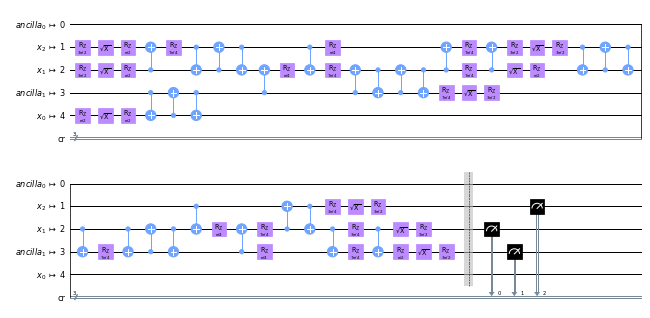

In [63]:
qc_optimized_G = transpile(qc_G, backend=backend_device, optimization_level=2)
qc_optimized_G.draw(output='mpl', scale=0.5)

In [64]:
qc_optimized_G.depth()

43

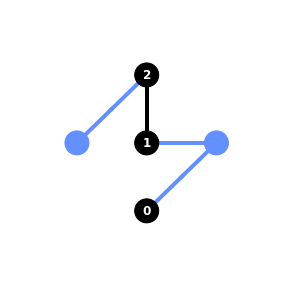

In [65]:
plot_circuit_layout(qc_optimized_G, backend_device)

In [66]:
job_exp = execute(qc_optimized_G, backend_device, shots = shots)

jobID = job_exp.job_id()

print('JOB ID: {}'.format(jobID))

job_exp.result().get_counts(qc_optimized_G)

JOB ID: 60bd3b72917aa009929b800c


{'000': 76,
 '001': 592,
 '010': 55,
 '011': 78,
 '100': 41,
 '101': 73,
 '110': 54,
 '111': 55}

In [67]:
job_get_G=backend_device.retrieve_job("60bd3b72917aa009929b800c")

result_real_G = job_get_G.result(timeout=3600, wait=5)

counts_opt_G = result_real_G.get_counts(qc_optimized_G)

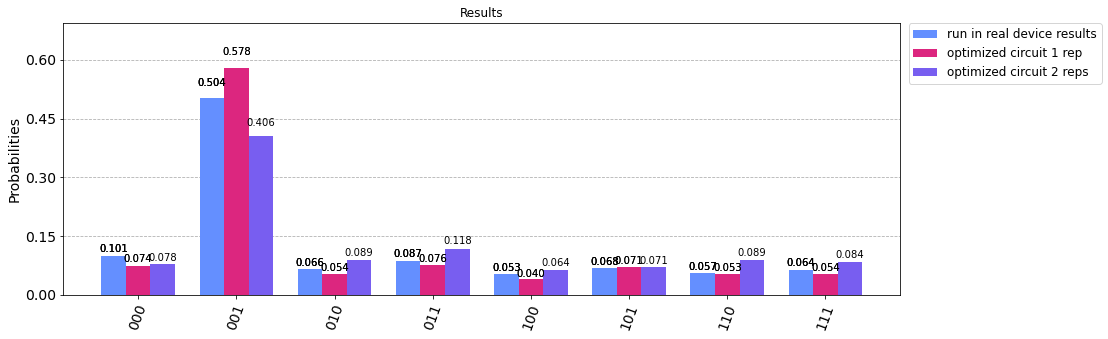

In [69]:
title = 'Results'
legend = ['run in real device results', 'optimized circuit 1 rep', 'optimized circuit 2 reps']

plot_histogram([counts_run,counts_opt_G,counts_opt], legend = legend, title= title, figsize=(15, 5))

As we can see, the optimized circuit with just one repetition has slightly better results than the one with the ideal amount of repetitions. This could be due to the depth of the optimized circuits, where a heigher depth can get a heigher chance of getting more errors.

#### Mitigation of Error with Ignis:

Now we are going to generate a list of measurement calibration circuits where each circuit creates a basis state.
Since we have 3 qubits, we need 8 calibration circuits.

In [70]:
qr = QuantumRegister(x)

meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr, circlabel='mcal')

In [71]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

Since we are going to use a real quantum device the calibration matrix will be different than the one simulated, this meaning that is going to be different from an eight by eight identity matrix.

In [72]:
job_ignis = execute(meas_calibs, backend=backend_device, shots=shots)

jobID_run_ignis = job_ignis.job_id()

print('JOB ID: {}'.format(jobID_run_ignis))

JOB ID: 60bd3ce943987e422cf116f4


In [73]:
job_get=backend_device.retrieve_job("60bd3ce943987e422cf116f4")

cal_results = job_get.result()

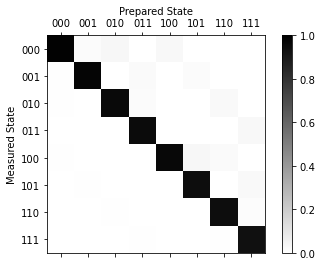

In [74]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

meas_fitter.plot_calibration()

In [75]:
print(meas_fitter.cal_matrix)

[[9.85351562e-01 1.75781250e-02 3.22265625e-02 0.00000000e+00
  2.83203125e-02 9.76562500e-04 9.76562500e-04 0.00000000e+00]
 [4.88281250e-03 9.77539062e-01 0.00000000e+00 2.24609375e-02
  0.00000000e+00 1.75781250e-02 0.00000000e+00 9.76562500e-04]
 [4.88281250e-03 0.00000000e+00 9.58007812e-01 1.85546875e-02
  0.00000000e+00 0.00000000e+00 2.53906250e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.92968750e-03 9.54101562e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.02734375e-02]
 [4.88281250e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.66796875e-01 3.41796875e-02 2.14843750e-02 0.00000000e+00]
 [0.00000000e+00 4.88281250e-03 0.00000000e+00 0.00000000e+00
  2.92968750e-03 9.45312500e-01 0.00000000e+00 2.44140625e-02]
 [0.00000000e+00 0.00000000e+00 6.83593750e-03 0.00000000e+00
  1.95312500e-03 0.00000000e+00 9.48242188e-01 1.17187500e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.88281250e-03
  0.00000000e+00 1.95312500e-03 3.90625000e-03 9.32617188e-01]]

In [76]:
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

Average Measurement Fidelity: 0.958496


In [77]:
meas_filter = meas_fitter.filter

mitigated_results = meas_filter.apply(result_r)
mitigated_counts = mitigated_results.get_counts()

And finally we get the following histogram.

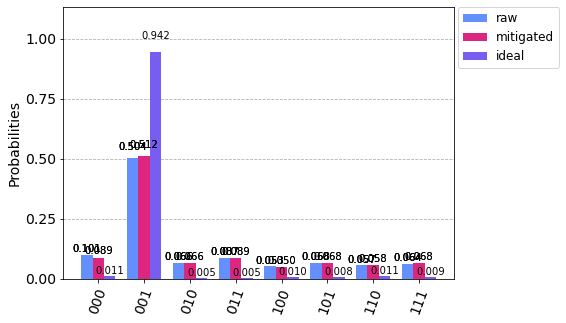

In [78]:
plot_histogram([counts_run, mitigated_counts, counts], legend=['raw', 'mitigated', 'ideal'])